## Part 1:  First Differenced Healthcare Spending vs Mortality 

In [44]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pycountry
import country_converter

from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

Helper fuction for country matching:

In [45]:
def ISO3(country_name):
    matches = { ## Hardcoding Strings pycountry won't catch
        'Bolivia (Plurinational State of)':'BOL',
        'Democratic Republic of the Congo':'COD',
        'Dem. Rep. Congo': 'COD',
        'Iran (Islamic Republic of)':'IRN',
        'Micronesia (Federated States of)':'FSM',
        'Türkiye': 'TUR',
        'TÃ¼rkiye': 'TUR',
        'Venezuela (Bolivarian Republic of)':'VEN',
        'Hong Kong SAR, China' : 'HKG',
        'SÃ£o TomÃ© and Principe' : 'STP',
        'Swaziland' : 'SWZ',
        'Laos' : 'LAO',
        'Lao PDR' : 'LAO',
        'Cape Verde' : 'CPV',
        "CÃ´te d'Ivoire": 'CIV'
    }
    if country_name in matches:
        return matches[country_name]
    try:
        return country_converter.convert(names=country_name)
    except:
        print(f'No Match for {country_name}')
        return None

Our Healthcare Spending data:

In [46]:
spend_df = pd.read_excel("P_Data_Extract_From_World_Development_Indicators.xlsx")
spend_df = spend_df.iloc[:-5]
spend_df = spend_df.loc[:, ~spend_df.columns.isin(['Series Name','Series Code'])]
spend_df = spend_df.melt(['Country Code','Country Name'], var_name='Year', value_name='Expenditure')
spend_df = spend_df.rename(columns={'Country Code': 'ISO3'})
spend_df = spend_df[~spend_df.Expenditure.isnull() & ~(spend_df.Expenditure=='..')]
spend_df.Year = spend_df.Year.str[0:4].astype(int)
spend_df


,ISO3,Country Name,Year,Expenditure
799,ALB,Albania,2000,80.616951
800,DZA,Algeria,2000,61.58218
802,AND,Andorra,2000,1302.620728
803,AGO,Angola,2000,12.998967
804,ATG,Antigua and Barbuda,2000,512.568298
...,...,...,...,...
6113,SSF,Sub-Saharan Africa,2019,78.86721
6114,SSA,Sub-Saharan Africa (excluding high income),2019,78.800014
6115,TSS,Sub-Saharan Africa (IDA & IBRD countries),2019,78.86721
6116,UMC,Upper middle income,2019,551.409396


To first difference:
First I'll sort by ISO3 and Year
Next, I'll use shift to add a column of % change
Next, I'll use shift() to add a column indicating if the preceding value is the same ISO3 and just a year before 
Next, I'll drop values where that isn't the case

In [47]:
spend_df = spend_df.sort_values(by=['ISO3', 'Year'])
spend_df['expenditure diff'] = spend_df['Expenditure'].pct_change()
spend_df['same_ISO'] = list(spend_df.ISO3.shift()==spend_df.ISO3)
spend_df.to_excel("spend_df.xlsx")
spend_df = spend_df[spend_df['same_ISO']]

In [48]:
spend_df.sort_values('expenditure diff')

,ISO3,Country Name,Year,Expenditure,expenditure diff,same_ISO
1108,COD,"Congo, Dem. Rep.",2001,6.038502,-0.696073,True
5771,SDN,Sudan,2018,59.514206,-0.691006,True
1337,ARG,Argentina,2002,223.848602,-0.668401,True
4940,PNG,Papua New Guinea,2015,48.73185,-0.489961,True
5490,SLE,Sierra Leone,2017,46.68697,-0.463962,True
...,...,...,...,...,...,...
1232,SRB,Serbia,2001,112.220634,0.986030,True
1740,NGA,Nigeria,2003,39.438438,1.166651,True
1069,AGO,Angola,2001,28.918121,1.224648,True
1758,RWA,Rwanda,2003,17.319206,1.372306,True


Our maternal mortality data:

In [49]:
mm_df = pd.read_excel("Data 2023-01-02 15-07.xlsx", sheet_name="Data")
mm_df = mm_df[['Year', 'Country', 'WHO region', 'Value Numeric']]
mm_df.columns = ['Year', 'Country', 'WHO region', 'Maternal Mortality']

In [50]:
countries = set(mm_df.Country)
iso3s = dict(zip(countries,country_converter.convert(names=countries)))
mm_df['ISO3']  = mm_df.apply(lambda row: iso3s[row.Country] , axis = 1)


In [51]:
mm_df

,Year,Country,WHO region,Maternal Mortality,ISO3
0,2000,Afghanistan,Eastern Mediterranean,1450,AFG
1,2001,Afghanistan,Eastern Mediterranean,1390,AFG
2,2002,Afghanistan,Eastern Mediterranean,1300,AFG
3,2003,Afghanistan,Eastern Mediterranean,1240,AFG
4,2004,Afghanistan,Eastern Mediterranean,1180,AFG
...,...,...,...,...,...
3289,2013,Zimbabwe,Africa,509,ZWE
3290,2014,Zimbabwe,Africa,494,ZWE
3291,2015,Zimbabwe,Africa,480,ZWE
3292,2016,Zimbabwe,Africa,468,ZWE


first differencing as before:

In [52]:
mm_df = mm_df.sort_values(by=['ISO3', 'Year'])
mm_df['mortality diff'] = mm_df['Maternal Mortality'].pct_change()
mm_df['same_ISO'] = mm_df.ISO3.shift()==mm_df.ISO3
mm_df.to_excel('mm_df.xlsx')
mm_df = mm_df[mm_df['same_ISO']]

In [53]:
mm_df

,Year,Country,WHO region,Maternal Mortality,ISO3,mortality diff,same_ISO
1,2001,Afghanistan,Eastern Mediterranean,1390,AFG,-0.041379,True
2,2002,Afghanistan,Eastern Mediterranean,1300,AFG,-0.064748,True
3,2003,Afghanistan,Eastern Mediterranean,1240,AFG,-0.046154,True
4,2004,Afghanistan,Eastern Mediterranean,1180,AFG,-0.048387,True
5,2005,Afghanistan,Eastern Mediterranean,1140,AFG,-0.033898,True
...,...,...,...,...,...,...,...
3289,2013,Zimbabwe,Africa,509,ZWE,-0.035985,True
3290,2014,Zimbabwe,Africa,494,ZWE,-0.029470,True
3291,2015,Zimbabwe,Africa,480,ZWE,-0.028340,True
3292,2016,Zimbabwe,Africa,468,ZWE,-0.025000,True


combining the two sources:

In [54]:
df = pd.merge(mm_df, spend_df, how='inner', on=['ISO3', 'Year'])
df = df.sort_values('expenditure diff')

In [55]:
df

,Year,Country,WHO region,Maternal Mortality,ISO3,mortality diff,same_ISO_x,Country Name,Expenditure,expenditure diff,same_ISO_y
576,2001,Democratic Republic of the Congo,Africa,740,COD,-0.026316,True,"Congo, Dem. Rep.",6.038502,-0.696073,True
67,2002,Argentina,Americas,65,ARG,-0.029851,True,Argentina,223.848602,-0.668401,True
2219,2015,Papua New Guinea,Western Pacific,151,PNG,-0.025806,True,Papua New Guinea,48.73185,-0.489961,True
2442,2017,Sierra Leone,Africa,1120,SLE,0.000000,True,Sierra Leone,46.68697,-0.463962,True
2494,2001,Suriname,Americas,218,SUR,-0.013575,True,Suriname,93.658989,-0.445538,True
...,...,...,...,...,...,...,...,...,...,...,...
2460,2001,Serbia,Europe,13,SRB,0.000000,True,Serbia,112.220634,0.986030,True
2020,2003,Nigeria,Africa,1170,NGA,-0.008475,True,Nigeria,39.438438,1.166651,True
15,2001,Angola,Africa,766,AGO,-0.073761,True,Angola,28.918121,1.224648,True
2326,2003,Rwanda,Africa,870,RWA,-0.094693,True,Rwanda,17.319206,1.372306,True


In [56]:
mm_df.sort_values(['mortality diff'])

,Year,Country,WHO region,Maternal Mortality,ISO3,mortality diff,same_ISO
757,2001,Cyprus,Europe,9,CYP,-0.357143,True
1412,2008,Iraq,Eastern Mediterranean,90,IRQ,-0.347826,True
269,2017,Belarus,Europe,2,BLR,-0.333333,True
2336,2014,Poland,Europe,2,POL,-0.333333,True
1464,2006,Italy,Europe,2,ITA,-0.333333,True
...,...,...,...,...,...,...,...
200,2002,Bahrain,Eastern Mediterranean,25,BHR,0.315789,True
761,2005,Cyprus,Europe,12,CYP,0.333333,True
770,2014,Cyprus,Europe,8,CYP,0.333333,True
1151,2017,Germany,Europe,7,DEU,0.400000,True


In [57]:
def PolynomialRegression(degree=2, **kwargs):
    return make_pipeline(PolynomialFeatures(degree),
                         LinearRegression(**kwargs))

In [58]:
model = PolynomialRegression(3)
X = df['expenditure diff'].values.reshape(-1, 1)
Y = df['mortality diff'].values.reshape(-1, 1)
model.fit(X, Y)
y_t = model.predict(X)

(-0.6, 1.0)

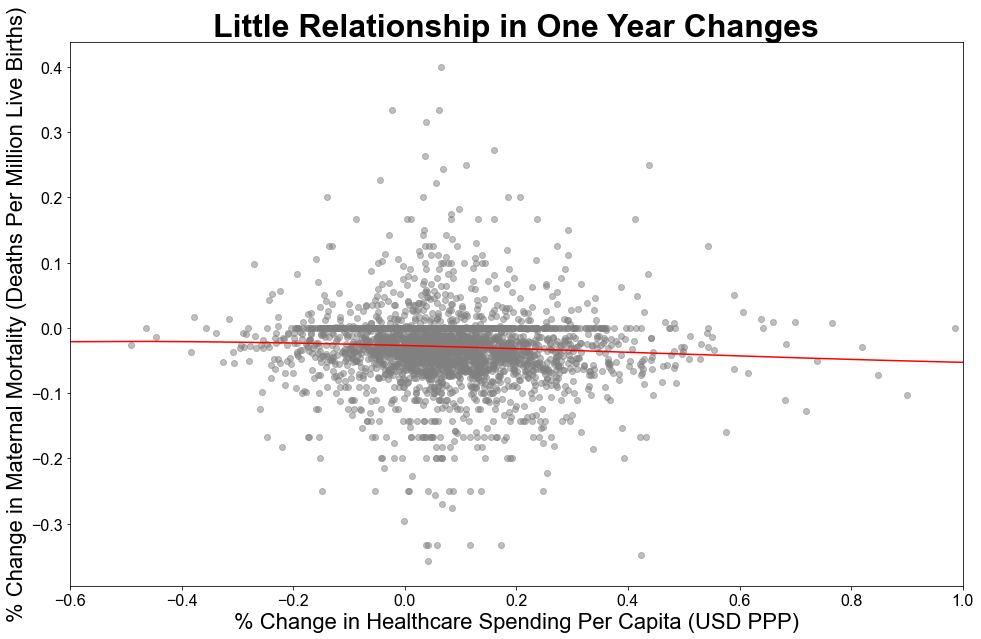

In [59]:
plt.rcParams['figure.figsize'] = [16, 10]

##Font size code stolen from StackOverflox (can't find where)
plt.rcParams["font.family"] = "Arial"

SMALL_SIZE = 16
MEDIUM_SIZE = 19
BIGGER_SIZE = 32

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=32)     # fontsize of the axes title
plt.rc('axes', labelsize=22)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=2)  # fontsize of the figure title


fig, ax = plt.subplots()
ax.set_title('Little Relationship in One Year Changes', weight='bold')
ax.set_xlabel('% Change in Healthcare Spending Per Capita (USD PPP)')
ax.set_ylabel('% Change in Maternal Mortality (Deaths Per Million Live Births)')
ax.scatter(X, Y, color='grey', alpha=0.5)
ax.plot(X, y_t, color='red')
ax.set_xlim([-0.6,1])

### Part 2: Healthcare Clustering:

Want data on:

    - Maternal Mortality
    - Life Expectency 
    - Expenditure
    - Coverage (from https://www.oecd-ilibrary.org/sites/524da6c0-en/index.html?itemId=/content/component/524da6c0-en)
    - Potential Years of Life Lost https://data.oecd.org/healthstat/potential-years-of-life-lost.htm#indicator-chart
    

the coverage data:

In [60]:
cov_df = pd.read_excel('coverage.xlsx', skiprows=33)
cov_df.columns = ['Country', 'Notes', 'Public', 'Private', 'Coverage']
cov_df = cov_df.iloc[:37]
cov_df = cov_df[['Country', 'Coverage']]

countries = set(cov_df.Country)
iso3s = dict(zip(countries,country_converter.convert(names=countries)))
cov_df['ISO3']  = cov_df.apply(lambda row: iso3s[row.Country] , axis = 1)

cov_df

,Country,Coverage,ISO3
0,Mexico,89.3,MEX
1,Costa Rica,90.0,CRI
2,United States,90.8,USA
3,Poland,92.6,POL
4,Chile,94.0,CHL
5,Hungary,94.0,HUN
6,Estonia,94.1,EST
7,Slovak Republic,94.6,SVK
8,Colombia,94.9,COL
9,Lithuania,98.1,LTU


potential years lost data:

In [61]:
pot_df = pd.read_csv('potential.csv')
pot_df = pot_df.sort_values(by='TIME')
pot_df = pot_df.drop_duplicates(subset=['LOCATION'], keep='last')

pot_df = pot_df[['LOCATION', 'Value']]
pot_df.columns = ['ISO3', 'Life Lost']

pot_df


,ISO3,Life Lost
41,PRT,4181.4
47,SWE,3225.9
59,CHL,4895.4
70,ZAF,18161.9
87,PER,5551.7
6,BEL,4039.8
12,DNK,3852.8
25,IRL,3512.9
66,RUS,10769.3
27,JPN,2994.8


and life expectency:

In [62]:
le_df = pd.read_excel("WPP2022_GEN_F01_DEMOGRAPHIC_INDICATORS_COMPACT_REV1.xlsx", skiprows=16)
le_df = le_df[['Region, subregion, country or area *', 'ISO3 Alpha-code','Year', 'Life Expectancy at Birth, both sexes (years)']]
le_df.columns = ['Country', 'ISO3', 'Year', 'Life Expectancy']
# Selecting only the most recent data
le_df = le_df.sort_values(by='Year').drop_duplicates(subset=['Country'], keep='last')
le_df = le_df[['ISO3', 'Life Expectancy']]

and selecting only our most recent mortality and spending data:

In [63]:
mm_df = mm_df.sort_values(by='Year').drop_duplicates(subset=['Country'], keep='last')
mm_df = mm_df[['Country','ISO3','Maternal Mortality']]

In [64]:
spend_df = spend_df.sort_values(by='Year').drop_duplicates(subset=['Country Name'], keep='last')
spend_df = spend_df[['ISO3', 'Expenditure']]

In [65]:
mm_df

,Country,ISO3,Maternal Mortality
17,Afghanistan,AFG,638
2645,Singapore,SGP,8
2357,Portugal,PRT,8
881,Dominican Republic,DOM,95
503,Cabo Verde,CPV,58
...,...,...,...
179,Azerbaijan,AZE,26
2825,Suriname,SUR,120
2141,Niger,NER,509
1907,Mauritius,MUS,61


merging all our data:

In [66]:
df = pd.merge(spend_df, mm_df, on='ISO3', how='inner')
df = pd.merge(df, le_df, on='ISO3', how='inner')
df = pd.merge(df, cov_df, on='ISO3', how='inner')
df = pd.merge(df, pot_df, on='ISO3', how='inner')
df = df[['ISO3', 'Country_x', 'Expenditure', 'Maternal Mortality', 'Life Expectancy', 'Coverage', 'Life Lost'	]]
df

,ISO3,Country_x,Expenditure,Maternal Mortality,Life Expectancy,Coverage,Life Lost
0,EST,Estonia,1598.818848,9,77.144,94.1,5977.7
1,CRI,Costa Rica,921.585754,27,77.023,90.0,5712.2
2,SWE,Sweden,5671.385742,4,82.983,100.0,3225.9
3,MEX,Mexico,540.372314,33,70.213,89.3,12474.8
4,RUS,Russian Federation,653.417236,17,69.419,99.7,10769.3
5,SVN,Slovenia,2219.100586,7,80.69,100.0,3927.1
6,LVA,Latvia,1166.797852,19,73.579,100.0,8137.5
7,DNK,Denmark,6003.325195,4,81.375,100.0,3852.8
8,LTU,Lithuania,1369.979492,8,73.72,98.1,8626.9
9,SVK,Slovakia,1342.074829,5,74.91,94.6,6221.6


Now Standardising!:

In [67]:
data = df[['Expenditure', 'Maternal Mortality', 'Life Expectancy', 'Coverage', 'Life Lost']]

# Create the scaler
scaler = StandardScaler()

# Normalizing
scaler.fit(data)
normalized_data = scaler.transform(data)

and performing K means:

In [68]:
# Create the KMeans model
kmeans = KMeans(n_clusters=4)

# Fit the model to the data
kmeans.fit(normalized_data)

# Predict the clusters
predicted_clusters = kmeans.predict(normalized_data)

and visualising the clusters:

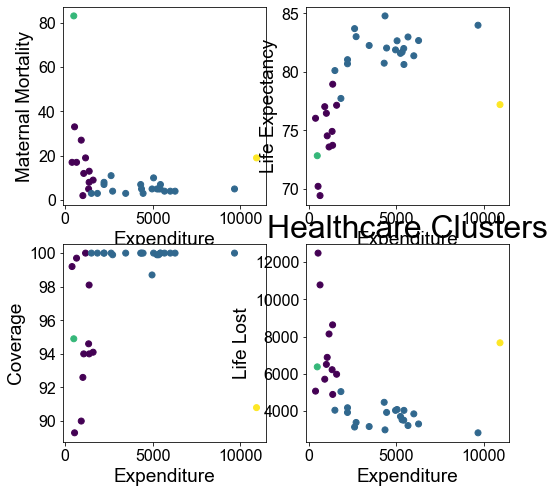

In [73]:

# Create a figure with 4 subplots
fig, ax = plt.subplots(2, 2, figsize=(8, 8))

# Define the dimensions to plot
dimensions = ['Maternal Mortality', 'Life Expectancy', 'Coverage', 'Life Lost']

# Loop over the dimensions and create a scatter plot for each one
for i, dimension in enumerate(dimensions):
    # Select the subplot
    axi = ax[i // 2, i % 2]
    # Scatter plot of Expenditure vs. the current dimension
    axi.scatter(df['Expenditure'], df[dimension], c=predicted_clusters, cmap='viridis')
    # Set the x and y labels
    axi.set_xlabel('Expenditure')
    axi.set_ylabel(dimension)
plt.title('Healthcare Clusters')

# Show the plots
plt.show()


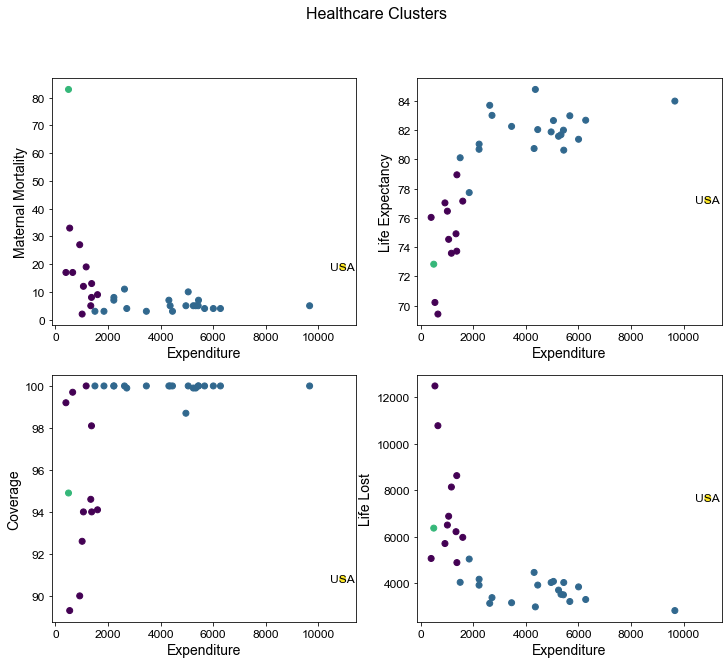

In [87]:
import matplotlib.pyplot as plt

##Font size code stolen from StackOverflox (can't find where)
plt.rcParams["font.family"] = "Arial"

SMALL_SIZE = 12
MEDIUM_SIZE = 14
BIGGER_SIZE = 16

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title


# Create a figure with 4 subplots
fig, ax = plt.subplots(2, 2, figsize=(12, 10))

# Define the dimensions to plot
dimensions = ['Maternal Mortality', 'Life Expectancy', 'Coverage', 'Life Lost']

# Loop over the dimensions and create a scatter plot for each one
for i, dimension in enumerate(dimensions):
    # Select the subplot
    axi = ax[i // 2, i % 2]
    # Scatter plot of Expenditure vs. the current dimension
    axi.scatter(df['Expenditure'], df[dimension], c=predicted_clusters, cmap='viridis')
    # Add the ISO3 labels to the points
    for x, y, label in zip(df['Expenditure'], df[dimension], [lab*(lab=='USA') for lab in df['ISO3'] ]):
        axi.text(x, y, label, ha='center', va='center')
    # Set the x and y labels
    axi.set_xlabel('Expenditure')
    axi.set_ylabel(dimension)

fig.suptitle("Healthcare Clusters")# Show the plots
plt.show()

In [42]:
"hello"*False

''

In [ ]:
dict(zip(countries,country_converter.convert(names=countries)))

{'Ghana': 'GHA',
 'Fiji': 'FJI',
 'Mauritius': 'MUS',
 'Uganda': 'UGA',
 'Trinidad and Tobago': 'TTO',
 'Lesotho': 'LSO',
 'United Arab Emirates': 'ARE',
 'Afghanistan': 'AFG',
 'Denmark': 'DNK',
 'Micronesia (Federated States of)': 'FSM',
 'Antigua and Barbuda': 'ATG',
 'Romania': 'ROU',
 'Viet Nam': 'VNM',
 'Liberia': 'LBR',
 'Montenegro': 'MNE',
 'Niger': 'NER',
 'China': 'CHN',
 'Malaysia': 'MYS',
 'Lithuania': 'LTU',
 'Chad': 'TCD',
 'Samoa': 'WSM',
 'Bosnia and Herzegovina': 'BIH',
 'South Sudan': 'SSD',
 'Angola': 'AGO',
 'Belarus': 'BLR',
 'Mexico': 'MEX',
 'Myanmar': 'MMR',
 'Iraq': 'IRQ',
 'Namibia': 'NAM',
 'Uzbekistan': 'UZB',
 'Norway': 'NOR',
 'Senegal': 'SEN',
 'Cyprus': 'CYP',
 'Togo': 'TGO',
 'Slovakia': 'SVK',
 'Benin': 'BEN',
 'Japan': 'JPN',
 'Honduras': 'HND',
 'Italy': 'ITA',
 'Mali': 'MLI',
 'Solomon Islands': 'SLB',
 'Equatorial Guinea': 'GNQ',
 'Sierra Leone': 'SLE',
 'Brazil': 'BRA',
 'Venezuela (Bolivarian Republic of)': 'VEN',
 'Pakistan': 'PAK',
 'Australia

In [ ]:
iso3s

{'Ghana': 'GHA',
 'Fiji': 'FJI',
 'Mauritius': 'MUS',
 'Uganda': 'UGA',
 'Trinidad and Tobago': 'TTO',
 'Lesotho': 'LSO',
 'United Arab Emirates': 'ARE',
 'Afghanistan': 'AFG',
 'Denmark': 'DNK',
 'Micronesia (Federated States of)': 'FSM',
 'Antigua and Barbuda': 'ATG',
 'Romania': 'ROU',
 'Viet Nam': 'VNM',
 'Liberia': 'LBR',
 'Montenegro': 'MNE',
 'Niger': 'NER',
 'China': 'CHN',
 'Malaysia': 'MYS',
 'Lithuania': 'LTU',
 'Chad': 'TCD',
 'Samoa': 'WSM',
 'Bosnia and Herzegovina': 'BIH',
 'South Sudan': 'SSD',
 'Angola': 'AGO',
 'Belarus': 'BLR',
 'Mexico': 'MEX',
 'Myanmar': 'MMR',
 'Iraq': 'IRQ',
 'Namibia': 'NAM',
 'Uzbekistan': 'UZB',
 'Norway': 'NOR',
 'Senegal': 'SEN',
 'Cyprus': 'CYP',
 'Togo': 'TGO',
 'Slovakia': 'SVK',
 'Benin': 'BEN',
 'Japan': 'JPN',
 'Honduras': 'HND',
 'Italy': 'ITA',
 'Mali': 'MLI',
 'Solomon Islands': 'SLB',
 'Equatorial Guinea': 'GNQ',
 'Sierra Leone': 'SLE',
 'Brazil': 'BRA',
 'Venezuela (Bolivarian Republic of)': 'VEN',
 'Pakistan': 'PAK',
 'Australia